In [4]:
import os
import glob
import re

import dynet as dy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def read_files(path: str, label: str):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(path+os.sep+label+os.sep+'*.txt')
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label))
        f.close()
    return texts

In [ ]:
def represent_text(text, n: int):
    """
    Extracts all character 'n'-grams from a given 'text'.
    Each digit is represented as a hashtag symbol (#) which in general denotes any number.
    Each hyperlink is replaced by an @ sign.
    The latter steps are computed through regular expressions.
    """    
    if n > 0:
        text = re.sub("[0-9]+(([.,^])[0-9]+)?", "#", text)
        text = re.sub("https:\\\+([a-zA-Z0-9.]+)?", "@", text)
        tokens = [text[i:i+n] for i in range(len(text)-n+1)]
    
    # create frequency text representation (keys are tokens, values are their corresponding frequencies)
    frequency = {token: tokens.count(token) for token in list(set(tokens))}
        
    return frequency

In [ ]:
def extract_vocabulary(texts, n: int, ft = 3):
    
    # Extracts all characer 'n'-grams occurring at least 'ft' times in a set of 'texts'
    occurrences=defaultdict(int)
    
    for (text,label) in texts:
        
        text_occurrences=represent_text(text,n)
        
        for ngram in text_occurrences.keys():
            
            if ngram in occurrences:
                occurrences[ngram] += text_occurrences[ngram]
            else:
                occurrences[ngram] = text_occurrences[ngram]
    
    vocabulary=[]
    for i in occurrences.keys():
        if occurrences[i] >= ft:
            vocabulary.append(i)
            
    return vocabulary

In [ ]:
def get_idf(word, documents):
    n_documents = 0
    for document in documents:
        if document.count(word) > 0:
            n_documents += 1
    return n_documents

In [ ]:
def tf_idf(documents, vocabulary):
    D = len(documents)
    weights_matrix = []
    for document in documents:
        unique_words_per_doc = set(document)
        one_hot_tf_idf = np.zeros(len(vocabulary))
        for word in unique_words_per_doc:
            for i, w in enumerate(vocabulary):
                if w == word:
                    tf = document.count(word) / len(document)
                    # if the term is not in the corpus, this will lead to a division-by-zero
                    # therefore, in the denominator we add the idf to 1
                    idf = np.log((D / (1 + get_idf(word, documents))))
                    one_hot_tf_idf[i] += tf * idf
                    break
        weights_matrix.append(one_hot_tf_idf)
    return weights_matrix

In [ ]:
def baseline(path,outpath,n_range=3,pt=0.1, lower = False):
    
    start_time = time.time()
    
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    problems = []
    language = []
    
    with open(infocollection, 'r') as f:
        for attrib in json.load(f):
            problems.append(attrib['problem-name'])
            language.append(attrib['language'])
            
    for index, problem in enumerate(problems):
        print(problem)
        # Reading information about the problem
        infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
        candidates = []
        with open(infoproblem, 'r') as f:
            fj = json.load(f)
            unk_folder = fj['unknown-folder']
            for attrib in fj['candidate-authors']:
                candidates.append(attrib['author-name'])
                
        # Building training set
        train_docs = []
        for candidate in candidates:
            train_docs.extend(read_files(path+os.sep+problem,candidate))
        train_texts = [text for i,(text,label) in enumerate(train_docs)]
        train_labels = [label for i,(text,label) in enumerate(train_docs)]
        
        vocab = []
        for n in range(2, n_range + 1):
            n_vocab = extract_vocabulary(train_docs, n, (n_range - n) + 1)
            vocab.extend(n_vocab)
        
        vectorizer = CountVectorizer(analyzer='char', ngram_range = (2, n_range), lowercase = lower, vocabulary = vocab)
        train_data = vectorizer.fit_transform(train_texts)
        train_data = train_data.toarray()
        train_data_pca = pca.fit(train_data)
        
        for i,v in enumerate(train_texts):
            train_data[i]=train_data[i]/len(train_texts[i])
            
        print('\t', 'language: ', language[index])
        print('\t', len(candidates), 'candidate authors')
        print('\t', len(train_texts), 'known texts')
        print('\t', 'vocabulary size:', len(vocabulary))
        
        # Building test set
        test_docs = read_files(path+os.sep+problem,unk_folder)
        test_texts = [text for i,(text,label) in enumerate(test_docs)]
        test_data = vectorizer.transform(test_texts)
        test_data = test_data.toarray()
        test_data_pca = pca.transform(n_components)
        
        for i,v in enumerate(test_texts):
            test_data[i]=test_data[i]/len(test_texts[i])
        print('\t', len(test_texts), 'unknown texts')
        
        # Applying SVM
        max_abs_scaler = preprocessing.MaxAbsScaler()
        scaled_train_data = max_abs_scaler.fit_transform(train_data)
        scaled_test_data = max_abs_scaler.transform(test_data)
        clf=CalibratedClassifierCV(OneVsRestClassifier(SVC(C=1)))
        clf.fit(scaled_train_data, train_labels)
        predictions=clf.predict(scaled_test_data)
        proba=clf.predict_proba(scaled_test_data)
        
        # Reject option (used in open-set cases)
        count=0
        for i,p in enumerate(predictions):
            sproba=sorted(proba[i],reverse=True)
            if sproba[0]-sproba[1]<pt:
                predictions[i]=u'<UNK>'
                count=count+1
        print('\t',count,'texts left unattributed')
        # Saving output data
        out_data=[]
        unk_filelist = glob.glob(path+os.sep+problem+os.sep+unk_folder+os.sep+'*.txt')
        pathlen=len(path+os.sep+problem+os.sep+unk_folder+os.sep)
        for i,v in enumerate(predictions):
            out_data.append({'unknown-text': unk_filelist[i][pathlen:], 'predicted-author': v})
        with open(outpath+os.sep+'answers-'+problem+'.json', 'w') as f:
            json.dump(out_data, f, indent=4)
        print('\t', 'answers saved to file','answers-'+problem+'.json')
    print('elapsed time:', time.time() - start_time)

In [125]:
def text_cleaning(document: list):
    """
    Cleans each document in the corpus accordingly.
    Converts each name to lower-case and only keeps strings,
    which contain alphabetical characters and have more than 1 character (similar to sklearn's CountVectorizer).
    Function filters for non-alpha characters (e.g., digits, special characters, punctuation marks).
    """
    cleaned_names = list()
    for name in document:
        
        if len(name) > 1:
            cleaned_name = ''.join([char for char in name if char.isalpha()]).lower()
            
            if len(cleaned_name) > 1:
                cleaned_names.append(cleaned_name)  

    return cleaned_names

In [126]:
# this function is only used for personal purposes but not for actual computation

def extract_vocabulary(names: list, n = 1):
    """
    Create vocabulary of character bigrams.
    Include bigrams, if and only if characters are alphabetical.
    Discard non-alphabetical characters (i.e., no bigrams will be created for non-alphabetical characters (e.g., digits, special characters)).
    """
    bigrams = []
    
    for name in names:
        for i, char in enumerate(name):
            if i > 0:
                # create character bigram, if and only if characters are alphabetical
                if name[i].isalpha() and name[i-n].isalpha():
                    bigram = name[i] + name[i-n] 
                    bigrams.append(bigram)
                else:
                    continue
    
    # vocabulary is a dictionary, where keys are unique bigrams and values are their corresponding frequency in the corpus
    vocab = {bigram: bigrams.count(bigram) for bigram in sorted(list(set(bigrams)))}
    return vocab 

In [127]:
all_names = names_english + names_german
vocab = extract_vocabulary(all_names)

In [31]:
def bag_of_chars(names_english: list, names_german: list, vocab = None):
    """
    Create a bag-of-character bigram representation of provided names.
    Vocabulary argument is set to None by default. 
    You can pass a vocabulary to this function, which will then be used for CountVectorizer. 
    """
    
    # initialize vectorizer (character-bigram representation)
    vectorizer = CountVectorizer(lowercase = True, ngram_range = (2, 2), analyzer = 'char')
    
    # represent names as bag-of-character bigrams
    all_names = text_cleaning(names_english) + text_cleaning(names_german)
    
    # create train set
    X_train = vectorizer.fit_transform(all_names).toarray()
    
    # create labels (0 for english names, 1 for german names)
    labels_eng = np.zeros(len(names_english), dtype = int) #[0 for name in names_english]
    labels_ger = np.ones(len(names_german), dtype = int) #[1 for name in names_german]
    
    # concatenate labels
    y_train = np.hstack((labels_eng, labels_ger))
    
    assert X_train.shape[0] == y_train.shape[0]
    
    vocab = sorted([bigram for bigram in vectorizer.vocabulary_.keys()])
    
    return X_train, y_train, vocab

In [32]:
X_train, y_train, vocab = bag_of_chars(names_english, names_german)

In [33]:
X_train, y_train = shuffle(X_train, y_train)

In [40]:
#MODEL SPECIFICATION
model = dy.ParameterCollection()

W_p = model.add_parameters((2, X_train.shape[1]))
b_p = model.add_parameters(2)

#trainer = dy.SimpleSGDTrainer(model)
trainer = dy.AdamTrainer(model) # adam is more efficient than stochastic gradient descent

num_epochs = 100
tolerance = 1e-6
losses = []

for epoch in range(num_epochs):
    
    cur_loss = 0

    for input_x, out_label in zip(X_train,y_train):
        
        dy.renew_cg() # create a new computation graph for each training example
        
        x = dy.inputVector(input_x) # this must go after renewing the graph
        
        # sigmoid activation function (for binary classification tasks)
        output_value = dy.logistic(W_p * x + b_p)
        
        # forward propagation (i.e., compute loss)
        loss = dy.hinge(output_value, out_label)

        loss_val = loss.value()
        cur_loss = cur_loss + loss_val
        
        # backward propagation (i.e., compute gradients)
        loss.backward()
        
        # update weights
        trainer.update()
        
    
    print(cur_loss/len(y_train))
    losses.append(cur_loss/len(y_train))
    
    if epoch > 0:
        diff = abs(losses[epoch - 1] - cur_loss/len(y_train))
        
        # if losses do not change significantly any longer, gradient descent has converged (break loop)
        if diff < tolerance: break

0.5918369834024615
0.34798219804066777
0.32447194521110134
0.3012735612541166
0.276217661770858
0.25976176490712033
0.24850757459419456
0.23962345723408818
0.23214402675411522
0.22564043971847314
0.21987740566550273
0.2147053768535998
0.21001896207884144
0.20574577014302947
0.2018376421895835
0.1982575746181884
0.19497210976204585
0.19195098531702176
0.1891682494180667
0.18660182296849773
0.18423224096686897
0.18204123883733767
0.18001100925799926
0.1781242705325177
0.1763647956084901
0.17471799460699433
0.17317115991819101
0.17171330053786762
0.17033486912376458
0.16902741329754636
0.16778337724764708
0.16659611458118279
0.16545987663916117
0.16436977608499198
0.16332173700323957
0.16231240868188426
0.16133906601339523
0.16039948294342976
0.15949174962625695
0.1586141287466216
0.15776486070538262
0.15694211496681462
0.15614397029896251
0.1553685539054306
0.15461414327712658
0.1538793571795488
0.1531632087025486
0.1524650583854573
0.151784551301072
0.15112153938776374
0.150476082155179

Text(0, 0.5, 'Loss')

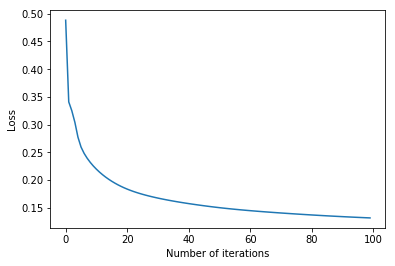

In [39]:
plt.plot(losses)
plt.xlabel("Number of iterations")
plt.ylabel("Loss")

In [29]:
import util
from itertools import count
import random
import time
from collections import defaultdict

In [30]:
class RNNLanguageModel:
    def __init__(self, model, LAYERS, INPUT_DIM, HIDDEN_DIM, VOCAB_SIZE, builder = dy.SimpleRNNBuilder):
        
        self.builder = builder(LAYERS, INPUT_DIM, HIDDEN_DIM, model)
        self.lookup = model.add_lookup_parameters((VOCAB_SIZE, INPUT_DIM), name="lookup")
        self.R = model.add_parameters((VOCAB_SIZE, HIDDEN_DIM), name="hidden2out")
        self.bias = model.add_parameters((VOCAB_SIZE), name="bias")

    def save_to_disk(self, filename):
        dy.save(filename, [self.builder, self.lookup, self.R, self.bias])

    def load_from_disk(self, filename):
        (self.builder, self.lookup, self.R, self.bias) = dy.load(filename, model)
        
    def build_lm_graph(self, sent):
        dy.renew_cg()
        init_state = self.builder.initial_state()

        errs = [] # will hold expressions
        es=[]
        state = init_state
        for (cw,nw) in zip(sent,sent[1:]):
            # assume word is already a word-id
            x_t = dy.lookup(self.lookup, int(cw))
            state = state.add_input(x_t)
            y_t = state.output()
            r_t = self.bias + (self.R * y_t)
            err = dy.pickneglogsoftmax(r_t, int(nw))
            errs.append(err)
        nerr = dy.esum(errs)
        return nerr
    
    def predict_next_word(self, sentence):
        dy.renew_cg()
        init_state = self.builder.initial_state()
        state = init_state
        for cw in sentence:
            # assume word is already a word-id
            x_t = self.lookup[int(cw)]
            state = state.add_input(x_t)
        y_t = state.output()
        r_t = self.bias + (self.R * y_t)
        prob = dy.softmax(r_t)
        return prob
        
    def sample(self, first=1, nchars=0, stop=-1):
        res = [first]
        dy.renew_cg()
        state = self.builder.initial_state()

        cw = first
        while True:
            x_t = self.lookup[cw]
            state = state.add_input(x_t)
            y_t = state.output()
            r_t = self.bias + (self.R * y_t)
            ydist = dy.softmax(r_t)
            dist = ydist.vec_value()
            rnd = random.random()
            for i,p in enumerate(dist):
                rnd -= p
                if rnd <= 0: break
            res.append(i)
            cw = i
            if cw == stop: break
            if nchars and len(res) > nchars: break
        return res

In [31]:
corpus = "allnames.txt"

LAYERS = 2
INPUT_DIM = 32 #50  #256
HIDDEN_DIM = 128 # 50  #1024

train = util.CharsCorpusReader(corpus, begin="<s>")
vocab = util.Vocab.from_corpus(train)

VOCAB_SIZE = vocab.size()

model = dy.Model()

trainer = dy.SimpleSGDTrainer(model, learning_rate=0.2)

lm = RNNLanguageModel(model, LAYERS, INPUT_DIM, HIDDEN_DIM, VOCAB_SIZE, builder=dy.SimpleRNNBuilder)
#lm = RNNLanguageModel(model, LAYERS, INPUT_DIM, HIDDEN_DIM, VOCAB_SIZE, builder=dy.LSTMBuilder)


train = list(train)

losses = []

chars = loss = 0.0

for ITER in range(3):
    random.shuffle(train)
    
    for i,sent in enumerate(train):
        _start = time.time()
        
        if i % 2500 == 0:
            trainer.status()
            print (i,len(train))
            
            if chars > 0: print(loss / chars,)
                
            for _ in range(1):
                samp = lm.sample(first=vocab.w2i["<s>"],stop=vocab.w2i["\n"])
                print("".join([vocab.i2w[c] for c in samp]).strip())
            loss = 0.0
            chars = 0.0

        chars += len(sent)-1
        isent = [vocab.w2i[w] for w in sent]
        errs = lm.build_lm_graph(isent)
        loss += errs.scalar_value()
        errs.backward()
        trainer.update()
    print ("TM:",(time.time() - _start)/len(sent))
    print("ITER {}, loss={}".format(ITER, loss))
    losses.append(loss)
    trainer.status()

lm.save_to_disk("RNNLanguageModel.model")

print("loading the saved model...")
lm.load_from_disk("RNNLanguageModel.model")
samp = lm.sample(first=vocab.w2i["<s>"],stop=vocab.w2i["\n"])
print("".join([vocab.i2w[c] for c in samp]).strip())


0 24158
<s>żzpVpúsãúIvżf ó
2500 24158
3.312249622638672
<s>Agüaer
5000 24158
3.3096209765548243
<s>Collin
7500 24158
3.315030470705376
<s>Sode
10000 24158
3.3302472654334774
<s>Araikkeskayy
12500 24158
3.341012694952305
<s>Charo
15000 24158
3.3434368001072747
<s>Elusi
17500 24158
3.341647548855079
<s>Cooper
20000 24158
3.3617703706721214
<s>At
22500 24158
3.3823963349407498
<s>Dejchenef
TM: 6.840626398722331e-05
ITER 0, loss=44670.92741680145
0 24158
3.3324078639911563
<s>Balanov
2500 24158
3.363216893229123
<s>Adniani
5000 24158
3.371980296670738
<s>Sasgol
7500 24158
3.3632297635702564
<s>Vanara
10000 24158
3.3505029714091425
<s>Jilyakov
12500 24158
3.361541686939542
<s>Gurin
15000 24158
3.3866671085333886
<s>Chena
17500 24158
3.362624272731542
<s>Eosion
20000 24158
3.3636006569254717
<s>Mis
22500 24158
3.3638998851674833
<s>Jonsi
TM: 6.514787673950195e-05
ITER 1, loss=45200.18455505371
0 24158
3.371889933237875
<s>Sapinh
2500 24158
3.365280220255356
<s>Roriechietu
5000 24158
3.359764